In [1]:
import os

import numpy as np
import pandas as pd

import matplotlib.dates as mdates
from matplotlib import pyplot
from github import Github

In [2]:
git = Github()
repo = git.get_repo('pr0nstar/covid19-data')

##### Mortalidad

In [3]:
mortality_dir = repo.get_contents('raw/mortality')
mortality_file = {
    os.path.basename(_.path): _ for _ in mortality_dir
}['south.america.subnational.mortality.csv']

In [4]:
df = pd.read_csv(mortality_file.download_url)
df['date'] = pd.to_datetime(df['date'])

geo_codes = {'PY-{}'.format(_):'PY-0{}'.format(_) for _ in range(1, 10)}
geo_codes['PE-LMA'] = 'PE-LIM'

df['adm1_isocode'] = df['adm1_isocode'].replace(geo_codes)
df = df.set_index(['iso_code', 'adm1_isocode', 'date'])
df = df.sort_index()

df.head(1)

,,,country_name,adm1_name,frequency,deaths
iso_code,adm1_isocode,date,,,,
BO,BO-B,2019-01-01,Bolivia,Beni,monthly,131


In [5]:
# Align Colombia
df_co = df.loc[['CO']].reset_index(level='date')
df_co['date'] = df_co['date'] - pd.DateOffset(days=1)
df_co = df_co.set_index('date', append=True)

df = df.drop('CO')
df = pd.concat([df, df_co])

In [6]:
# Drop Brasil 2018
df_br = df.loc[['BR']].reset_index(level='date')
df_br = df_br[df_br['date'] < '2019'].set_index('date', append=True)

df = df.drop(df_br.index)

In [7]:
location_df = df[['country_name', 'adm1_name']]
location_df = location_df.droplevel([0, 2])
location_df = location_df.drop_duplicates()
location_df.head(1)

,country_name,adm1_name
adm1_isocode,,
BO-B,Bolivia,Beni


##### Fallecimientos COVID

In [8]:
paho_dir = repo.get_contents('raw/paho')
paho_dir_dict = {
    os.path.basename(_.path): _ for _ in paho_dir
}
paho_deaths_file = paho_dir_dict['deaths.timeline.csv']
paho_deaths_patch_file = paho_dir_dict['deaths.timeline.daily.patch.csv']

In [9]:
paho_df = pd.read_csv(paho_deaths_file.download_url, header=[0, 1], index_col=0)
paho_patch_df = pd.read_csv(paho_deaths_patch_file.download_url, header=[0, 1], index_col=0)

paho_df.update(paho_patch_df)
paho_df.index = pd.to_datetime(paho_df.index)

paho_df.head(1)

ISO3_CODE      ABW  ARG                                          ...  VEN  \
ADM1_ISOCODE AW-01 AR-A AR-B AR-C AR-D AR-E AR-F AR-G AR-H AR-J  ... VE-W   
DATA_DATE                                                        ...        
2020-01-21     NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN   

ISO3_CODE                     VGB               VIR              
ADM1_ISOCODE VE-X VE-Y VE-Z VG-01 VG-04 VG-05 VI-01 VI-02 VI-03  
DATA_DATE                                                        
2020-01-21    NaN  NaN  NaN   NaN   NaN   NaN   NaN   NaN   NaN  

[1 rows x 623 columns]

##### Curvas

In [10]:
def stylize_ax(ax, label, loc='upper left'):
    if type(ax) == np.ndarray:
        [stylize_ax(_, loc) for _ in ax]
        return
    
    ax.grid(b=True, color='DarkTurquoise', alpha=0.2, linestyle=':', linewidth=2)
    
    lines, labels = ax.get_legend_handles_labels()
    ax.legend(lines[:1], [label], loc=loc, framealpha=.3)
    
    
def align_precovid(pre_covid_df, total_years=1):
    dept = pre_covid_df.name
    pre_covid_df_index = pre_covid_df.index.isocalendar()
    
    pre_covid_df = pre_covid_df.to_frame().set_index([
        pre_covid_df_index.year, pre_covid_df_index.week
    ])
    pre_covid_df = pre_covid_df.unstack(level=1)[dept]
    
    for _ in range(total_years):
        pre_covid_df = pd.concat([pre_covid_df, pre_covid_df], axis=1)

    pre_covid_df.columns = pd.date_range(
        '2020', periods=len(pre_covid_df.columns), freq='W'
    )
    
    return pre_covid_df
    
    
def do_plot(covid_mortality_df, registered_covid_df, ax=None):
    during_covid_df = covid_mortality_df.loc['2020':]
    pre_covid_df = covid_mortality_df.loc[:'2019']
    
    pre_covid_df = align_precovid(
        pre_covid_df, 
        len(during_covid_df.index.year.unique()) - 1
    )

    if ax is None:
        fig, ax = pyplot.subplots(figsize=(50/2.54, 25/2.54))

    pre_covid_df.mean().plot(
        color='tab:blue', 
        label='Promedio',
        ax=ax
    )

    ax = during_covid_df.plot(
        ax=ax, 
        color='midnightblue', 
        label='Fallecimientos', 
        linewidth=2
    )

    registered_covid_df_weekly = registered_covid_df.copy()
    registered_covid_df_weekly = registered_covid_df_weekly[
        registered_covid_df_weekly.replace(0, np.nan).first_valid_index():
    ]
#     registered_covid_df_weekly[covid_mortality_df['2020':].index[0]] = 0
    registered_covid_df_weekly = registered_covid_df_weekly.sort_index()
    registered_covid_df_weekly = registered_covid_df_weekly.resample('W').mean().fillna(0)

    registered_covid_df_weekly = registered_covid_df_weekly + pre_covid_df.mean()

    registered_covid_df_weekly.plot(
        ax=ax, label='COVID confirmado', color='red'
    )
    ax.fill_between(
        registered_covid_df_weekly.index, 
        registered_covid_df_weekly, 
        pre_covid_df.mean()[:len(registered_covid_df_weekly)], 
        color='red', 
        alpha=.3
    )
    
    if len(pre_covid_df) > 1:
        std = pre_covid_df.stack().std()
        (registered_covid_df_weekly + std).plot(
            ax=ax, linestyle=':', color='tab:red', label='Max'
        )

        (pre_covid_df.mean() - std).plot(
            ax=ax, linestyle=':', color='tab:blue', label='Min'
        )

    ax.set_xlim(during_covid_df.index.min(), during_covid_df.index.max())
    label = location_df.loc[covid_mortality_df.name]['adm1_name']
    stylize_ax(ax, label)
    
    return ax

In [11]:
mortality_df = pd.DataFrame([])
today = pd.to_datetime('today').round('d')

for iso_code, country_mortality_df in df.groupby(level=0):
    country_mortality_df = country_mortality_df.droplevel(0)
    country_data_freq = country_mortality_df['frequency'].iloc[0]

    if country_data_freq == 'daily':
        country_mortality_df = country_mortality_df.groupby([
            pd.Grouper(level='adm1_isocode'),
            pd.Grouper(level='date', freq='D')
        ])['deaths'].mean()
        country_mortality_df = country_mortality_df.interpolate('linear')
        country_mortality_df = country_mortality_df.unstack(level=0)
        country_mortality_df = country_mortality_df.resample('W').sum()

    elif country_data_freq == 'monthly':
        country_mortality_df = country_mortality_df['deaths'].unstack(level=0)
        country_mortality_df_index = country_mortality_df.index[0]
        country_mortality_df.index = country_mortality_df.index + pd.DateOffset(months=1, days=-1)
        country_mortality_df.loc[country_mortality_df_index - pd.DateOffset(days=2)] = 0
        country_mortality_df = country_mortality_df.sort_index()
        
        if country_mortality_df.index[-1] > today:
            country_mortality_df = country_mortality_df.rename(
                index={country_mortality_df.index[-1]: today - pd.DateOffset(days=1)}
            )
        
        country_mortality_df = country_mortality_df.cumsum().asfreq('d')
        country_mortality_df = country_mortality_df.interpolate('from_derivatives')
        country_mortality_df = country_mortality_df.diff().dropna().resample('W').sum()

    else:
        country_mortality_df = country_mortality_df['deaths'].unstack(level=0)
        
    mortality_df = pd.concat([mortality_df, country_mortality_df], axis=1)
    
mortality_df = mortality_df.loc['2017':].dropna(how='all')
mortality_df.head(1)

adm1_isocode,BO-B,BO-C,BO-H,BO-L,BO-N,BO-O,BO-P,BO-S,BO-T,BR-AC,...,PY-09,PY-10,PY-11,PY-12,PY-13,PY-14,PY-15,PY-16,PY-19,PY-ASU
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,23.258065,45.741935,131.0,6.516129,13.548387,8.193548,6.129032,0.870968,4.967742,137.709677


In [12]:
covid_deaths_df = pd.DataFrame([])

for country_key, country_data in paho_df.groupby(level=0, axis=1):
    if country_data.iloc[-1].sum() > 100:
        country_data = country_data.drop_duplicates().asfreq('D')
        country_data = country_data.interpolate('from_derivatives', limit_area='inside')
    
    covid_deaths_df = pd.concat([covid_deaths_df, country_data], axis=1)

In [13]:
covid_deaths_df = covid_deaths_df.T.droplevel(0)
covid_deaths_df = covid_deaths_df.loc[
    mortality_df.columns
].T

In [14]:
for _ in range(3):
    covid_deaths_df[(covid_deaths_df.diff() < 0).shift(-1).fillna(False)] = np.nan
    covid_deaths_df = covid_deaths_df.interpolate('from_derivatives', limit_area='inside')
    
for _ in range(3):
    covid_deaths_df[covid_deaths_df.diff() < 0] = np.nan
    covid_deaths_df = covid_deaths_df.interpolate('from_derivatives', limit_area='inside')
    
covid_deaths_df = covid_deaths_df.round().dropna(how='all')
covid_deaths_df = covid_deaths_df.diff().fillna(covid_deaths_df)
covid_deaths_df = covid_deaths_df.resample('W').sum()

covid_deaths_df.head(1)

adm1_isocode,BO-B,BO-C,BO-H,BO-L,BO-N,BO-O,BO-P,BO-S,BO-T,BR-AC,...,PY-09,PY-10,PY-11,PY-12,PY-13,PY-14,PY-15,PY-16,PY-19,PY-ASU
DATA_DATE,,,,,,,,,,,,,,,,,,,,,
2020-03-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
mortality_df_limit = mortality_df.apply(lambda _: _.last_valid_index())
# right censoring
mortality_df_limit = mortality_df_limit - pd.DateOffset(weeks=2)

In [16]:
covid_deaths_df_agg = covid_deaths_df.apply(lambda _: _[:mortality_df_limit[_.name]])

mortality_df_agg = mortality_df[:'2019']
mortality_df_agg = mortality_df_agg.apply(lambda _: align_precovid(_).mean())

mortality_current_df_agg = mortality_df['2020':].apply(
    lambda _: _[:mortality_df_limit[_.name]]
).sum()

sub_registered_mortality_rank = (mortality_df_agg + covid_deaths_df_agg).dropna(how='all').sum()
sub_registered_mortality_rank = (sub_registered_mortality_rank / mortality_current_df_agg).sort_values()

In [17]:
mortality_df = mortality_df[sub_registered_mortality_rank.index]
mortality_df = mortality_df[mortality_df.columns[(mortality_df > 70).any()]]
mortality_df = mortality_df.round()

mortality_df.index.name = ''

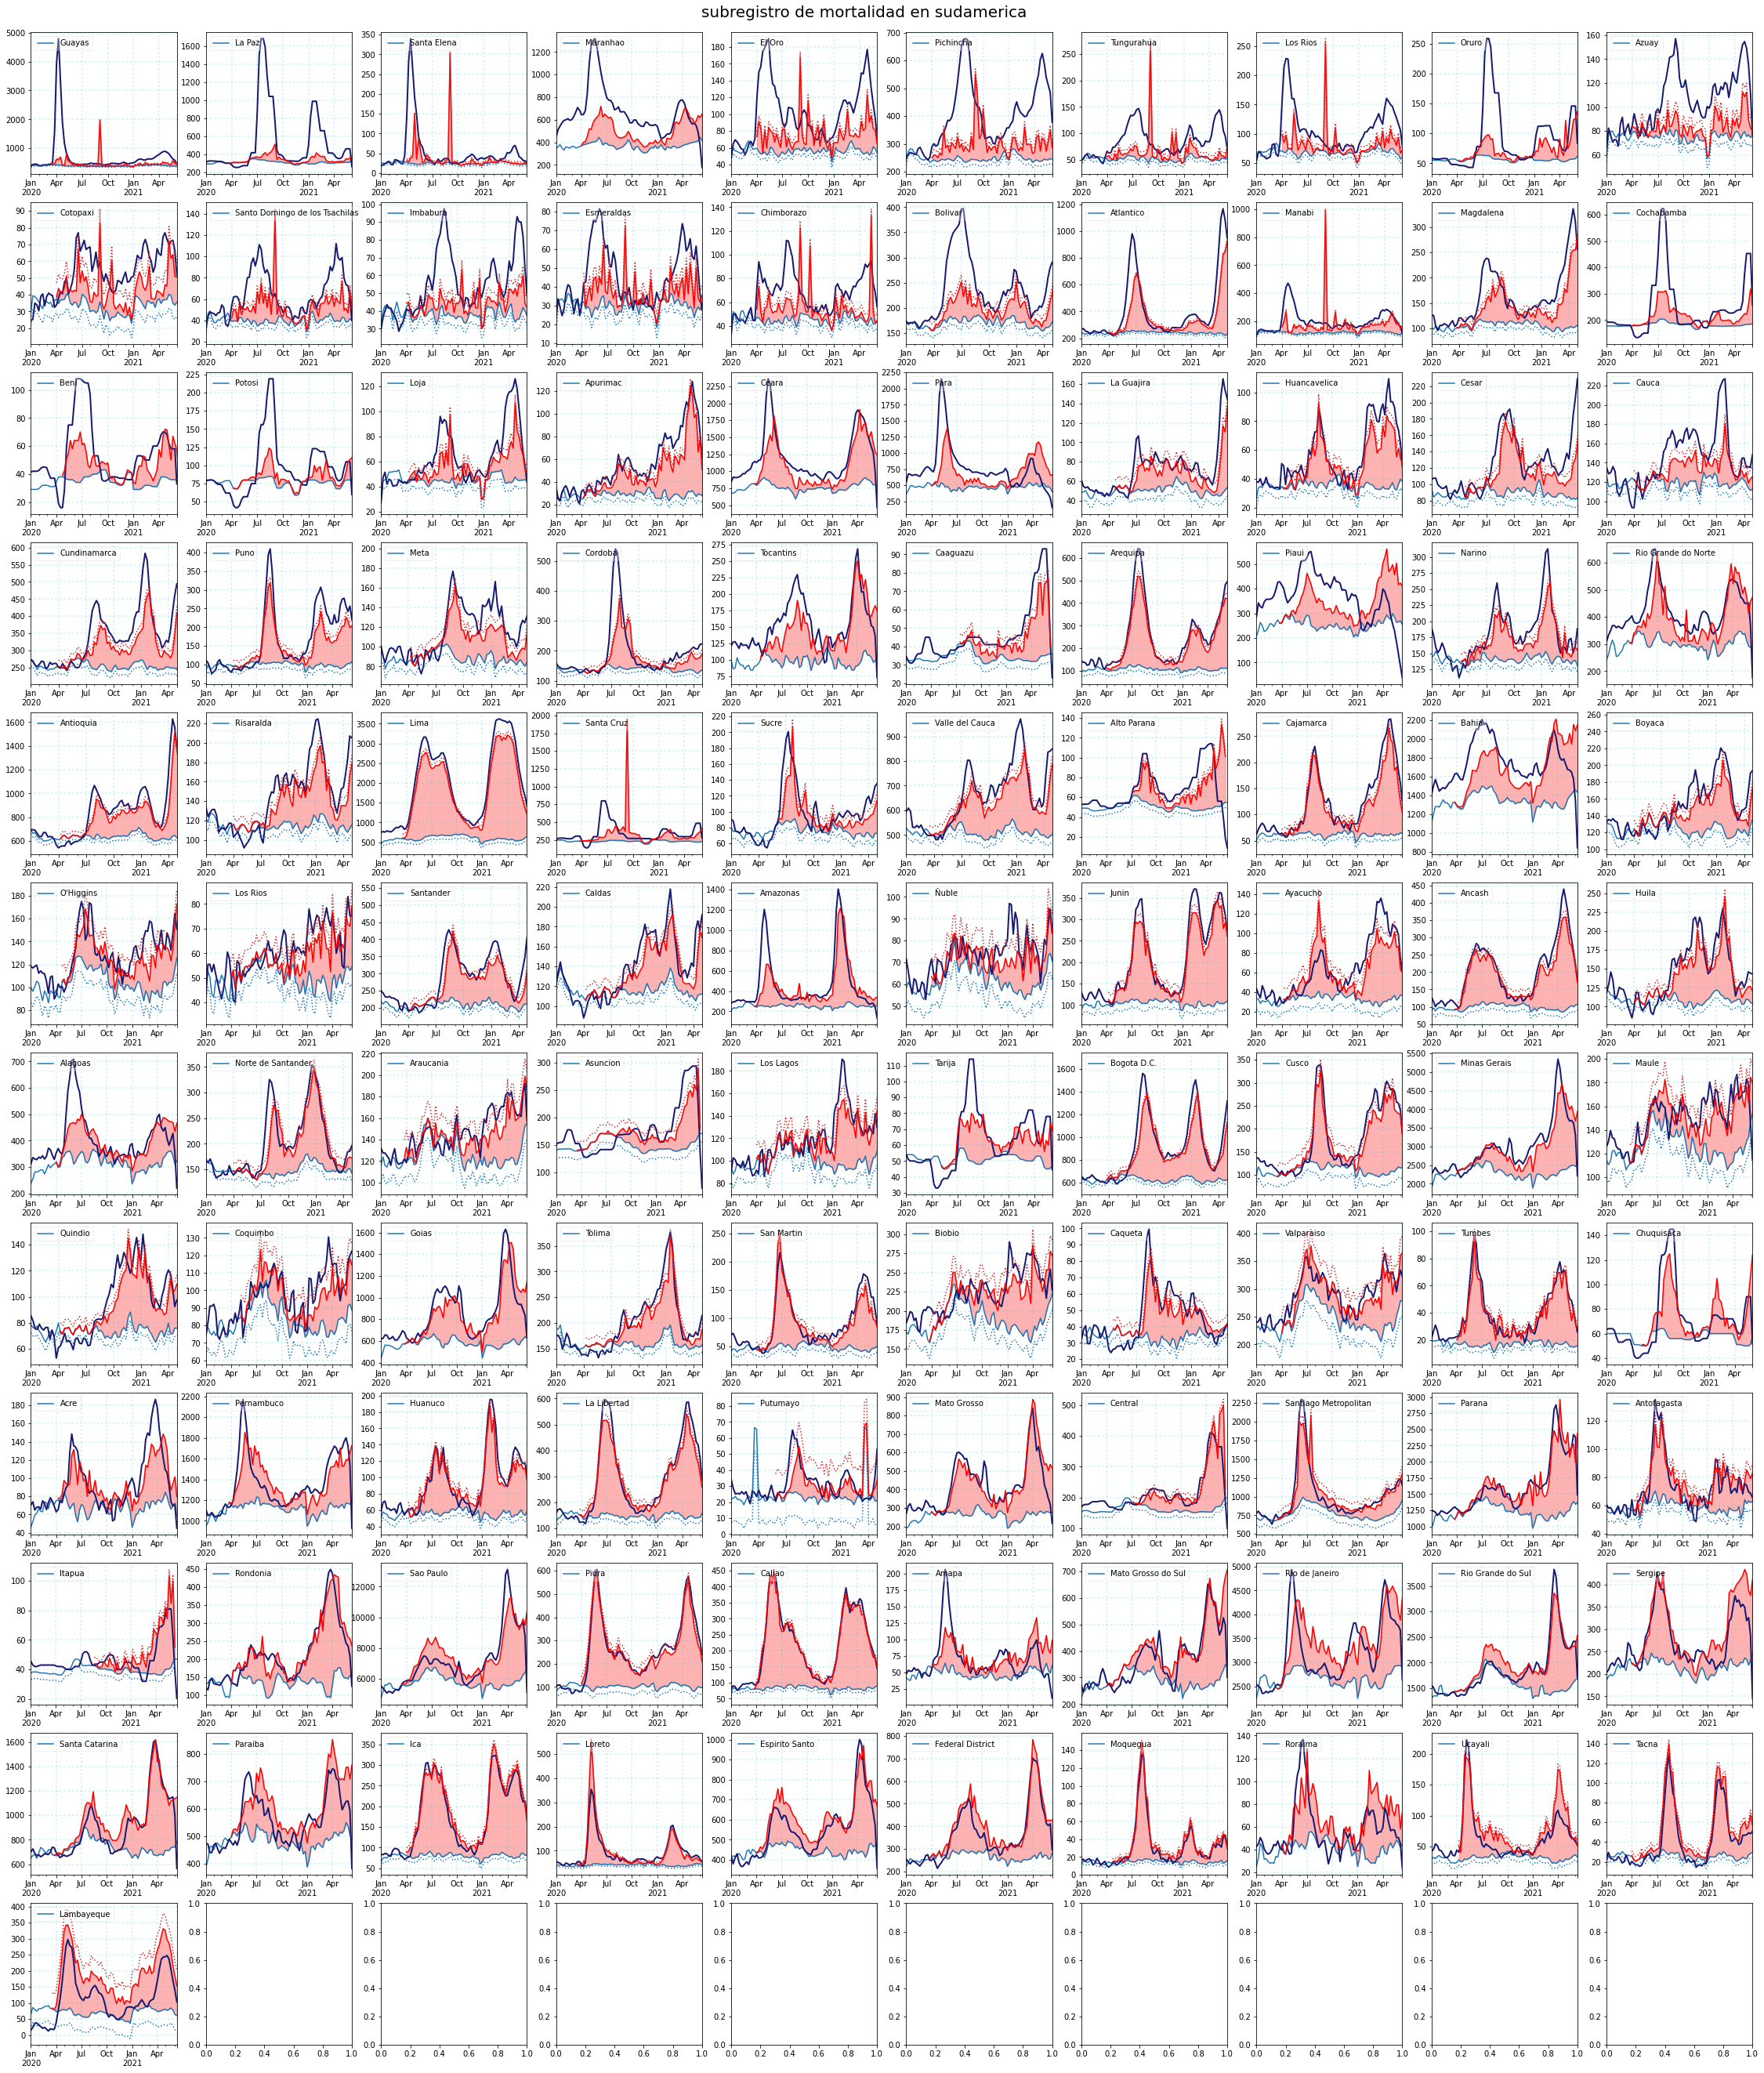

In [18]:
ncols = 10
nrows = np.ceil(len(mortality_df.columns) / ncols)

fig, axs = pyplot.subplots(
    ncols=ncols, 
    nrows=int(nrows), 
    figsize=(10 * ncols/2.54, 10 * nrows/2.54)
)
axs = axs.flatten()

for idx, item in enumerate(mortality_df.iteritems()):
    dept, covid_mortality_df = item
    
    covid_mortality_df = covid_mortality_df.dropna()
    registered_covid_df = covid_deaths_df[dept]
    
    do_plot(
        covid_mortality_df.rolling(window=2).mean().fillna(covid_mortality_df),
        registered_covid_df,
        ax=axs[idx]
    )
    
_ = fig.suptitle('subregistro de mortalidad en sudamerica', fontsize=20, y=.89)
fig.savefig('../img/mortality.subregistration.jpg', bbox_inches='tight')